# BASIC #

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from stock_trading_environment import StockTradingEnvironment, Positions

import dqn
from dqn import ReplayMemory, DQN

import plot_dqn as plot

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

In [2]:
#function for saving trained models in a folder
def uniquify(path):
    filename, extension = os.path.splitext(path)
    counter = 1

    while os.path.exists(path):
        path = filename + " (" + str(counter) + ")" + extension
        counter += 1

    return path

In [3]:
#autoreload modified modules
%load_ext autoreload
%autoreload 2

# DATA PIPELINE #

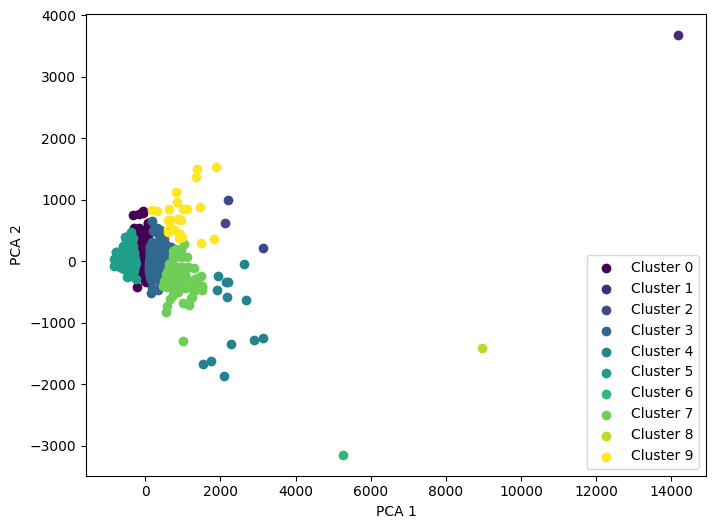

In [4]:
'''
Data pipeline:
    - Read filtered stocks closing prices as CSV/in SQL
    - Find clusters with kmeans and PCA
    - Filter out some outlier clusters; key clusters # as a dict
    - Find cointegration of each key cluster and plot heatmap
'''
import data_pipeline as pipeline
import config

pgConnStr = config.pgDictToConn(config.pgSecrets)
random_state = 42

n_clusters = 10
dailyDF = pipeline.getDailyPrices(pipeline.getDailyPricesTickersLst(pgConnStr), pgConnStr)

#if read dailyDF from saved Excel file
#dailyDF = pd.read_excel('./data/dailyDF_230408.xlsx', header=1, index_col=0, skiprows=0, parse_dates=True)
#dailyDF.index = pd.to_datetime(dailyDF.index)

clusters = pipeline.findStockClusters(dailyDF, n_clusters)
good_clusters_dict = pipeline.findStocksinClusters(clusters, n_clusters)
pipeline.plotStockClusters(clusters)

In [49]:
#if need to save dailyDF as an Excel
'''
dailyDFcopy = dailyDF.copy()
dailyDFcopy.index = dailyDFcopy.index.tz_convert(None)
dailyDFcopy.to_excel('./data/dailyDF_230408.xlsx')
'''

In [5]:
#just to check how many stocks in each cluster
for i in good_clusters_dict.keys():
    print(f'cluster {i}: {len(dailyDF[good_clusters_dict[i]].columns)} stocks')

cluster 0: 345 stocks
cluster 3: 214 stocks
cluster 4: 13 stocks
cluster 5: 409 stocks
cluster 7: 80 stocks
cluster 9: 25 stocks


[('GCBC', 'OVBC'), ('GCBC', 'TSBK'), ('GCBC', 'BBU'), ('OVBC', 'CBFV'), ('CHSCN', 'HQH'), ('CHSCN', 'CHSCL'), ('CHSCN', 'CHSCM'), ('HQH', 'STRS'), ('HQH', 'CHSCL'), ('HQH', 'CHSCM'), ('HQH', 'EPAC'), ('HSTM', 'STRS'), ('HSTM', 'OLP'), ('DCOM', 'STRS'), ('DCOM', 'EPAC'), ('CMPS', 'OLP'), ('CMPS', 'EPAC'), ('MAX', 'VSTO'), ('BSRR', 'STRS'), ('BSRR', 'MMYT'), ('BSRR', 'DXPE'), ('STEL', 'DXPE'), ('GNTY', 'STRS'), ('GNTY', 'ETO'), ('GNTY', 'EPAC'), ('STRS', 'OCFC'), ('STRS', 'HTBI'), ('STRS', 'CBFV'), ('STRS', 'ETO'), ('STRS', 'MMYT'), ('STRS', 'EPAC'), ('STRS', 'OPOF'), ('STRS', 'EQBK'), ('STRS', 'DXPE'), ('CHSCL', 'CHSCM'), ('CHSCL', 'ALCO'), ('OCFC', 'MMYT'), ('OCFC', 'DXPE'), ('HMST', 'STK'), ('HMST', 'QQQX'), ('TSBK', 'DXPE'), ('WLDN', 'ALRS'), ('CHSCM', 'EPAC'), ('HTBI', 'DXPE'), ('IIIN', 'ALRS'), ('HESM', 'HTD'), ('HESM', 'BBU'), ('HESM', 'MMYT'), ('HESM', 'EPAC'), ('HESM', 'DXPE'), ('MMYT', 'OPOF'), ('MMYT', 'EQBK'), ('MMYT', 'DXPE')]


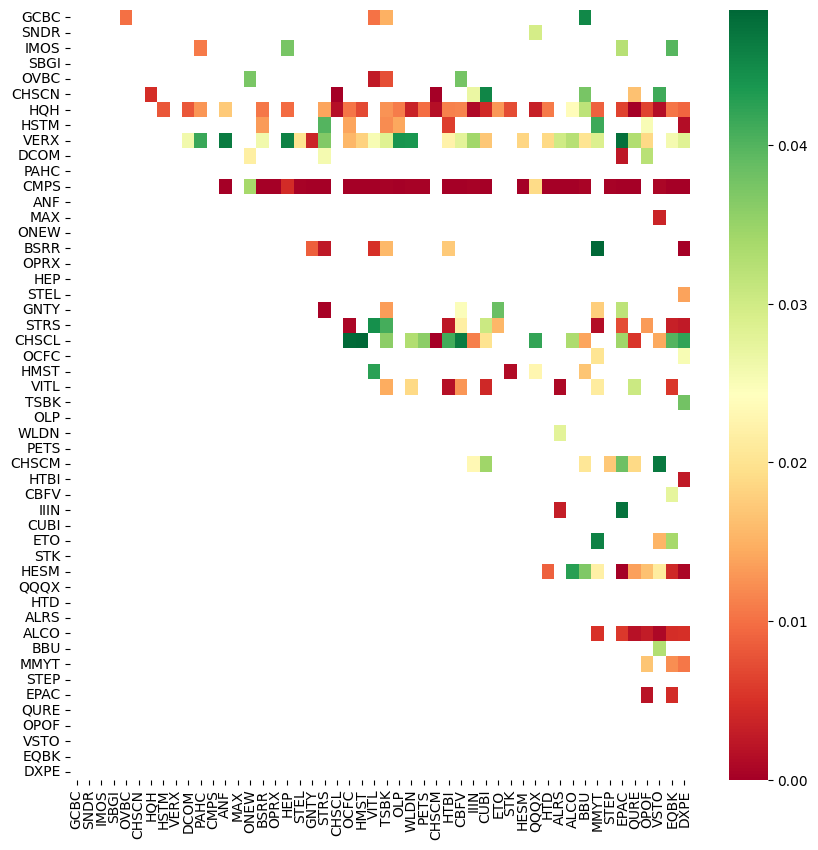

In [15]:
#split train/test data by time: 70/30#
#manually choose cluster of a reasonable size (80-100 stocks) AND REASONABLY DISPERSED for training model
dailyDF_train = dailyDF[good_clusters_dict[3]]

train_startdate = dailyDF_train.index[0]
train_enddate = train_startdate + pd.DateOffset(years=5)
trainpairs, trainpval, traindf = pipeline.cointHeatmap(dailyDF_train.loc[train_startdate:train_enddate].dropna(axis=1, how='all'), 
                                                       random_state)

In [16]:
#create trainenvs
window_size = 60
#trade_period = 5
transaction_cost = 0.05

trainenvs = []
for trainpair in trainpairs:
    traindata = traindf[list(trainpair)].dropna()
    if traindata.shape[0] > 450:
        trainenvs.append(StockTradingEnvironment(traindata.copy(), window_size, transaction_cost))   #instantiate an env; automatatically run trade()


In [17]:
print(f'The no. of trainpairs and trainevns are respectively {len(trainpairs)} and {len(trainenvs)}.')

The no. of trainpairs and trainevns are respectively 53 and 48.


[('CZNC', 'ITRN'), ('CZNC', 'DCOM'), ('CZNC', 'FNLC'), ('ECCC', 'HTIBP'), ('PAHC', 'GIII'), ('OLP', 'RM'), ('CCD', 'PTA'), ('DCOM', 'GNTY'), ('HFBL', 'HTIBP'), ('GBAB', 'GIII'), ('DFP', 'GIII'), ('DFP', 'SBGI'), ('WLDN', 'GIII'), ('DXPE', 'REYN'), ('OCFC', 'REYN'), ('GIII', 'SBGI')]


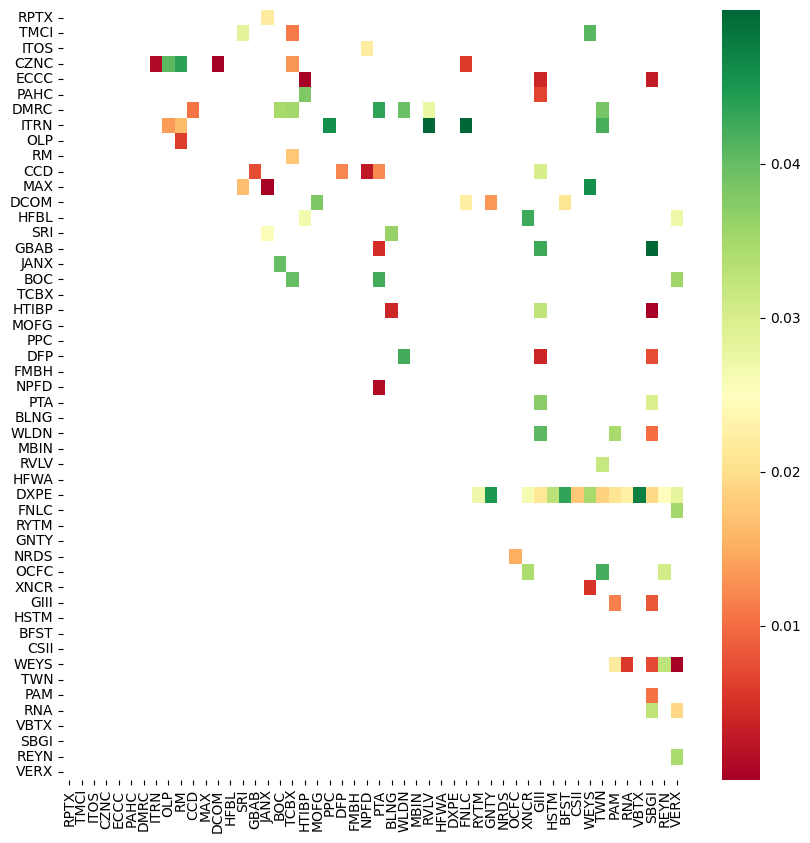

In [18]:
#val set heatmap
valpairs, valpval, valdf = pipeline.cointHeatmap(dailyDF_train.loc[train_enddate:].dropna(axis=1, how='all'), 
                                                 random_state=random_state)

In [19]:
#create valenvs
valenvs = []
for valpair in valpairs:
    valdata = valdf[list(valpair)].dropna()
    if valdata.shape[0] > 250:
        valenvs.append(StockTradingEnvironment(valdata.copy(), window_size, transaction_cost))   #instantiate an env; automatatically run trade()

In [20]:
print(f'The no. of validation pairs and validation evns are respectively {len(valpairs)} and {len(valenvs)}.')

The no. of validation pairs and validation evns are respectively 16 and 16.


# DEEP Q-NETWORK #

In [21]:
BATCH_SIZE = 256   #increased fom 128
GAMMA = 0.95          #decreased from 0.999
EPS_START = 0.9
EPS_END = 0.02   #decreased from 0.05
EPS_DECAY = 2000  #increased from 200
TARGET_UPDATE = 5

# Get number of actions from gym action space
n_actions = 2   #only trade or not_trade

policy_net = DQN(window_size + 2, n_actions, device).to(device)   #input size depends on length of status/obs; here window_size=60=past 60 zscores
target_net = DQN(window_size + 2, n_actions, device).to(device)
target_net.load_state_dict(policy_net.state_dict())   #target_net loads state_dict of policy_net
target_net.eval()   #set target_net to evaluate mode

optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-6)   #from torch.optim; RMSprop = optimizer like SGD or Adam; lr decreased from 1e-4
memory = ReplayMemory(127000)   #increased from 10000

In [53]:
#training agent
num_episodes = 120
best_rewards = 0
steps_done = 0

#empty dicts to collect train/test rewards/returns
train_reward_dict = {}
train_return_dict = {}
val_reward_dict = {}
val_return_dict = {}


for i_episode in range(num_episodes):
    policy_net.train()   #sets mode to training mode
    train_rewards = []
    train_returns = []

    #initialize train_reward_dict and train_return_dict for this
    train_reward_dict[i_episode] = []
    train_return_dict[i_episode] = []
    val_reward_dict[i_episode] = []
    val_return_dict[i_episode] = []

    #initialize nn_counter for this episode
    nn_counter = 0
    
    for trainenv in trainenvs:
    #for env in [testinst]:
        # Initialize the environment and state
        obs = trainenv.reset()   #reset() will get (zscore, [self._position.value, self.pvalue])
        state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
        
        for t in count():   #keep looping until done -> break
            # Select and perform an action and return whether this action is returned by policy_network
            action, nn_count = policy_net.select_action(state, EPS_START, EPS_END, EPS_DECAY, steps_done, policy_net, n_actions)   #epsilon-greedy: exploit or explore; state is this state
            #obs, reward, done, info = trainenv.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            obs, step_reward, done, info, step_return = trainenv.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            #reward is step_reward for this step
            #obs, reward, done = env.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            
            #append reward and return of this episode in the list
            train_reward_dict[i_episode].append(step_reward)
            train_return_dict[i_episode].append(step_return)
            
            step_reward = torch.tensor([step_reward], dtype=torch.float, device=device)
            step_return = torch.tensor([step_return], dtype=torch.float, device=device)

            # Observe new state
            if not done:
                next_state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            else:
                next_state = None

            # Store the transition in memory
            #current state status, action, next state status, reward
            #each state means 60 past zscores + current action + pvalue
            #each memory pushes 62 + 62 + 3 = 127 
            memory.push(state, action, next_state, step_reward)

            # Move to the next state
            state = next_state

            #tick steps_done to trigger epsilon-greedy
            steps_done += 1
            nn_counter += nn_count

            #new
            #train_rewards.append(reward)

            # Perform one step of the optimization (on the policy network)
            policy_net.optimize_model(memory, BATCH_SIZE, policy_net, target_net, GAMMA, optimizer)   #optimize policy network with back propagation
            if done:
                train_rewards.append(info['total_reward'])
                train_returns.append(info['total_return'])
                break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:   #update target network every 5 episodes
        target_net.load_state_dict(policy_net.state_dict())   #update target network with policy network parameters
    
    # Validation
    policy_net.eval()   #validate, so set policy network at eval mode
    val_rewards = []
    val_returns = []
    with torch.no_grad():
        for valenv in valenvs:
            
            obs = valenv.reset()
            state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            for t in count():   #keep looping until done -> break
                # Select and perform an action
                action = policy_net(state).max(1)[1].view(1, 1)   #action returned by policy_net given state
                obs, step_reward, done, info, step_return = valenv.step(Positions(action.item()))   #take a step based on action returned by nn
                #obs, reward, done = env.step(Positions(action.item()))   #take a step based on action returned by nn
                state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)

                #new
                #test_rewards.append(reward)

                #append reward and return of this episode in the list
                val_reward_dict[i_episode].append(step_reward)
                val_return_dict[i_episode].append(step_return)

                if done:
                    val_rewards.append(info['total_reward'])
                    val_returns.append(info['total_return'])
                    break

    avg_rewards = np.mean(val_rewards)
    if (avg_rewards > best_rewards) and (i_episode != 0):   #disregarding the 1st model because the 1st model often has highest score and it's useless to save
        best_rewards = avg_rewards
        torch.save(policy_net.state_dict(), uniquify('./models/model.pth'))   #save trained model (policy_net) as a state_dict for future use

    print('epoch [{}/{}], train rewards:{:.4f}, returns:{:.4f}, val rewards:{:.4f}, returns:{:.4f}, policy_nn_actions:{}, training steps:{}'.format
          (i_episode + 1, num_episodes, np.mean(train_rewards), np.mean(train_returns), np.mean(val_rewards),
           np.mean(val_returns), nn_counter, len(train_reward_dict[i_episode])))

print('Complete')

epoch [1/120], train rewards:-9.4044, returns:-3.4722, val rewards:3.0131, returns:3.3461, policy_nn_actions:73644, training steps:77040
epoch [2/120], train rewards:-11.7375, returns:-5.1124, val rewards:1.8420, returns:2.1955, policy_nn_actions:75464, training steps:77040
epoch [3/120], train rewards:-12.4255, returns:-6.2635, val rewards:3.0369, returns:3.3448, policy_nn_actions:75480, training steps:77040
epoch [4/120], train rewards:-12.9587, returns:-7.0255, val rewards:1.6474, returns:2.0557, policy_nn_actions:75535, training steps:77040
epoch [5/120], train rewards:-11.1328, returns:-5.5519, val rewards:1.6931, returns:1.9623, policy_nn_actions:75498, training steps:77040
epoch [6/120], train rewards:-10.7123, returns:-5.5409, val rewards:1.9121, returns:2.2453, policy_nn_actions:75482, training steps:77040
epoch [7/120], train rewards:-10.2832, returns:-4.8528, val rewards:2.0662, returns:2.3766, policy_nn_actions:75528, training steps:77040
epoch [8/120], train rewards:-9.870

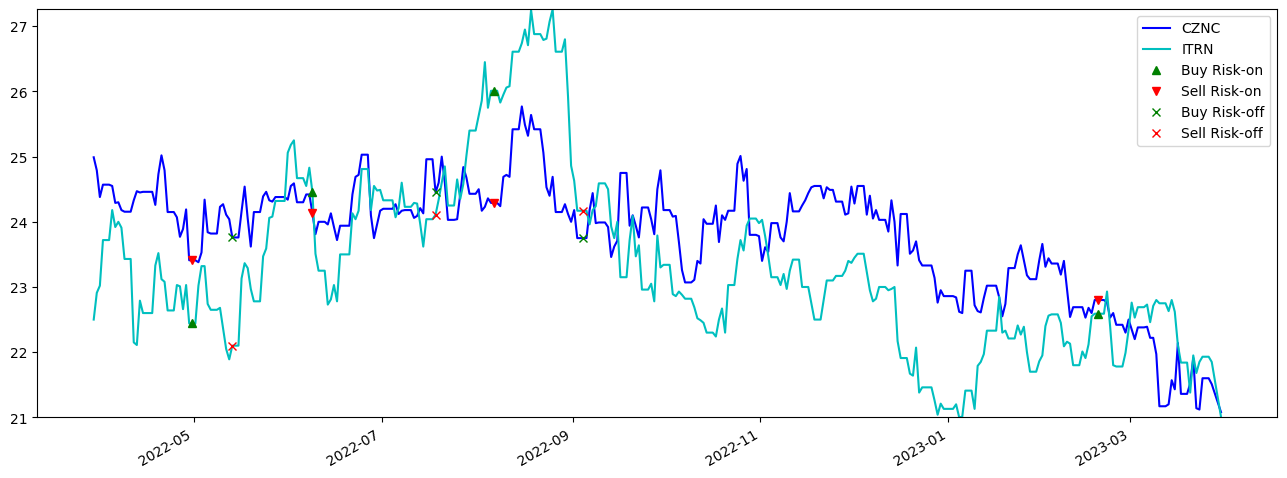

Total reward for this pair: -3.4595021415237612
Total return for this pair: -3.4595021415237612


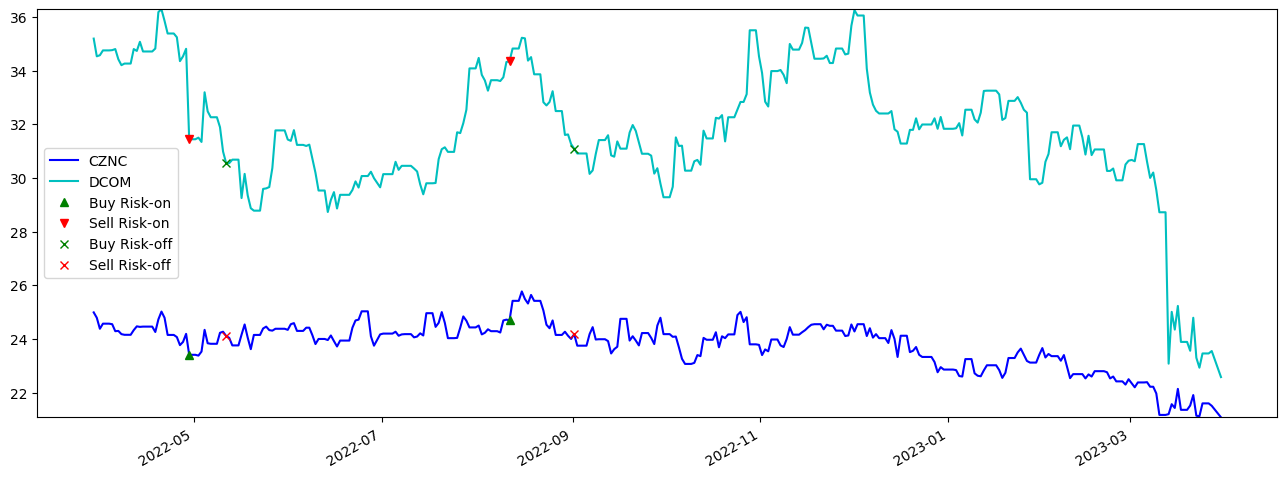

Total reward for this pair: 3.3718670123632943
Total return for this pair: 3.3718670123632943


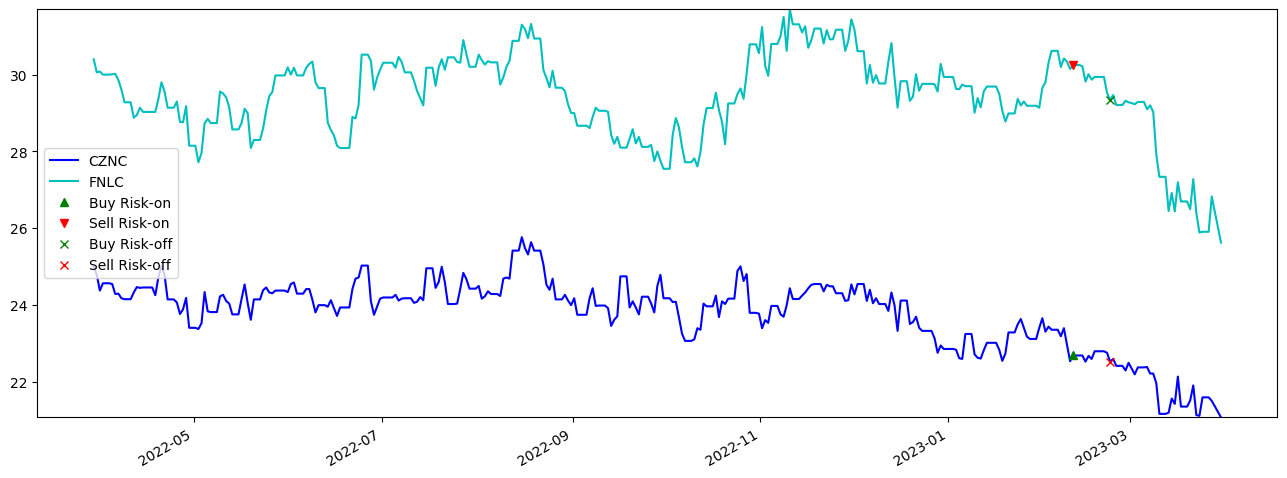

Total reward for this pair: 0.7039921234253455
Total return for this pair: 0.7039921234253455


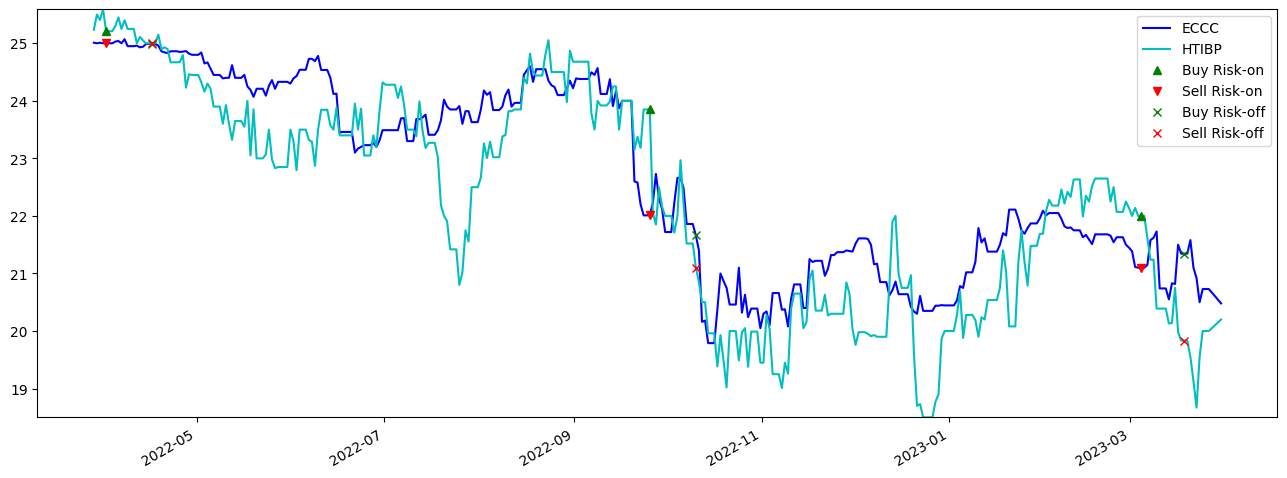

Total reward for this pair: -5.221184058746386
Total return for this pair: -5.221184058746386


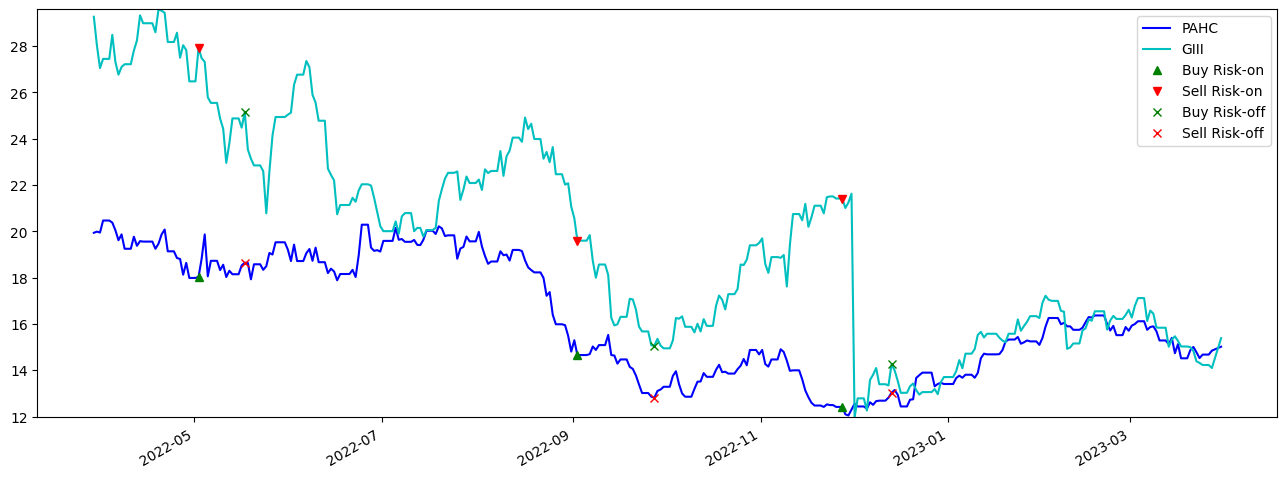

Total reward for this pair: 9.491071919463888
Total return for this pair: 9.491071919463888


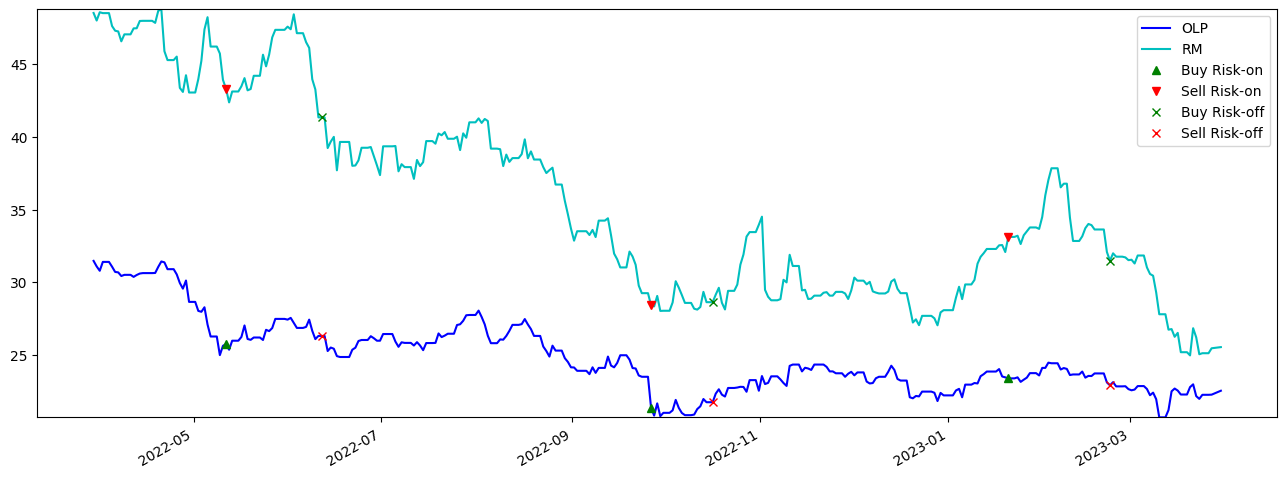

Total reward for this pair: 11.424915360408036
Total return for this pair: 11.424915360408036


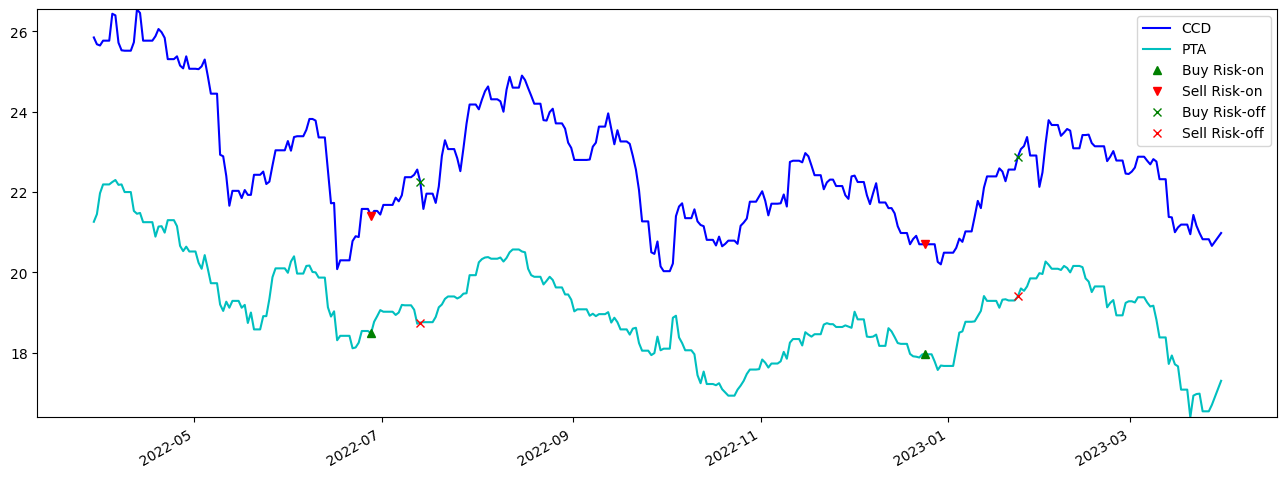

Total reward for this pair: -2.5785542581963634
Total return for this pair: -2.5785542581963634


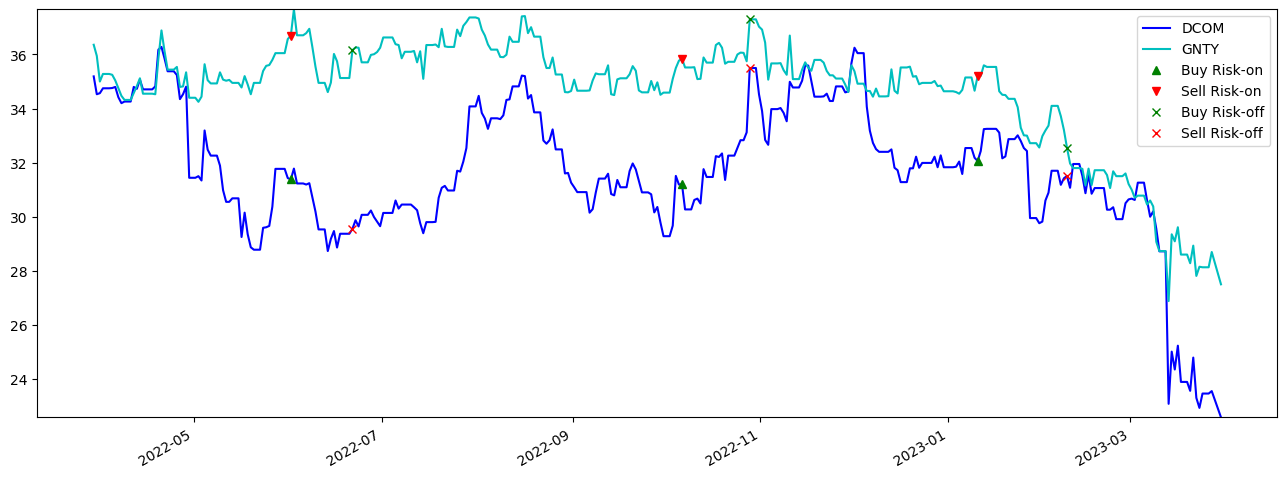

Total reward for this pair: 9.21243371050866
Total return for this pair: 9.21243371050866


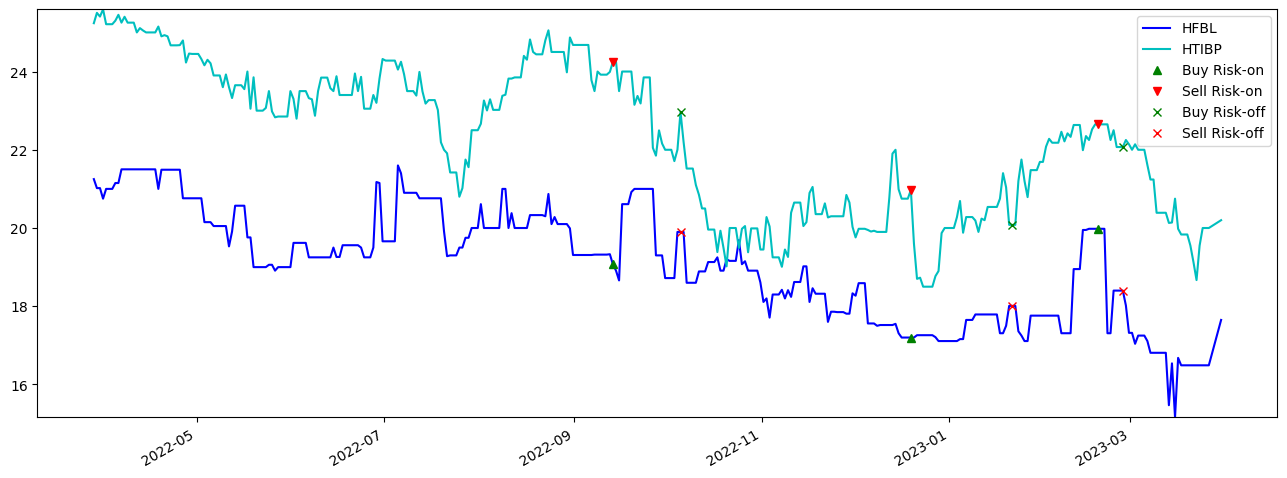

Total reward for this pair: 2.2034370825336627
Total return for this pair: 2.2034370825336627


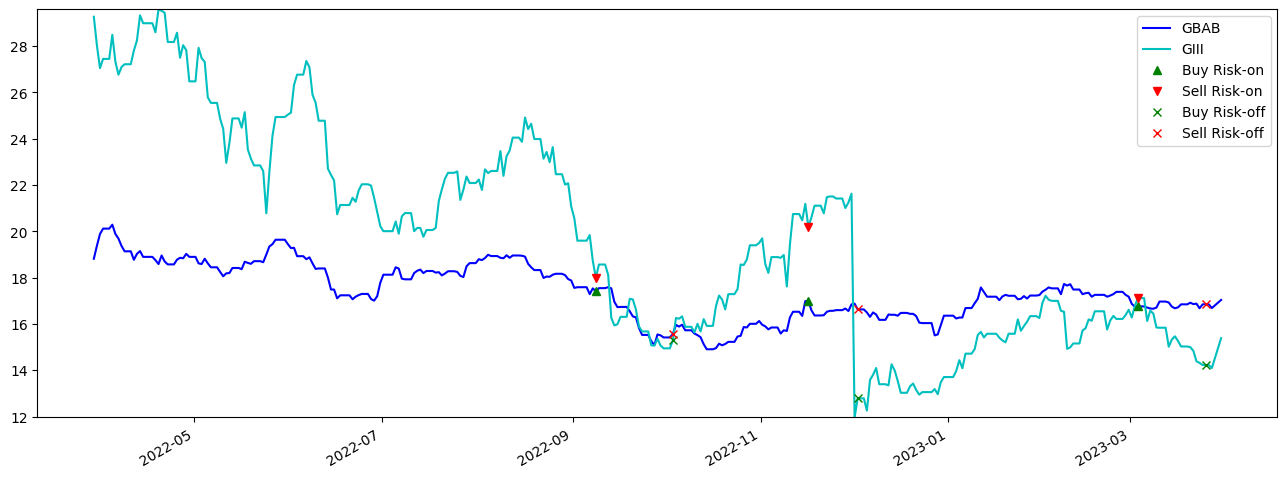

Total reward for this pair: 12.690536547615078
Total return for this pair: 12.690536547615078


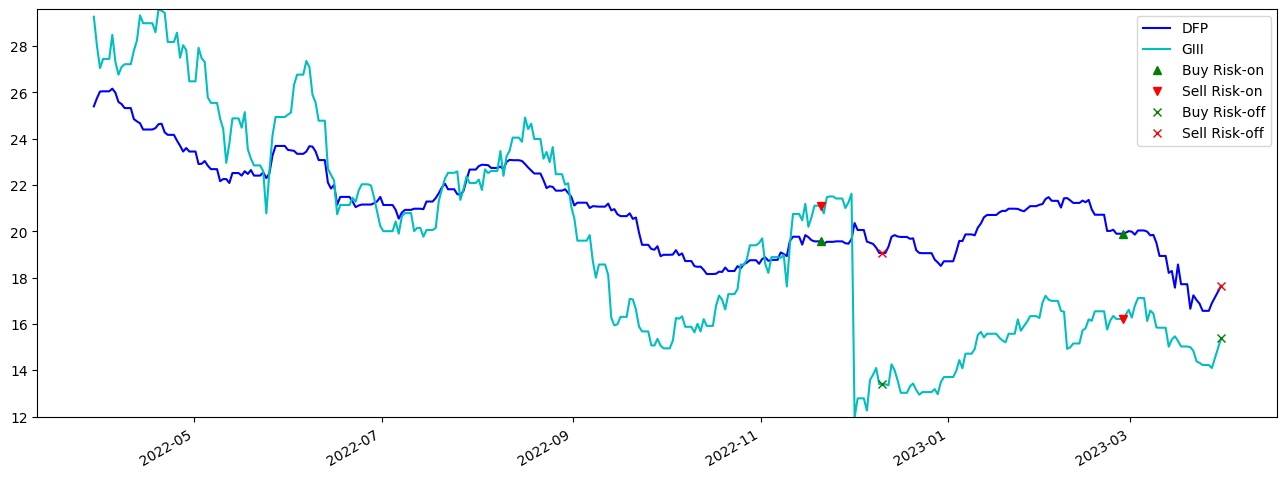

Total reward for this pair: 7.939518978920646
Total return for this pair: 8.021030965535106


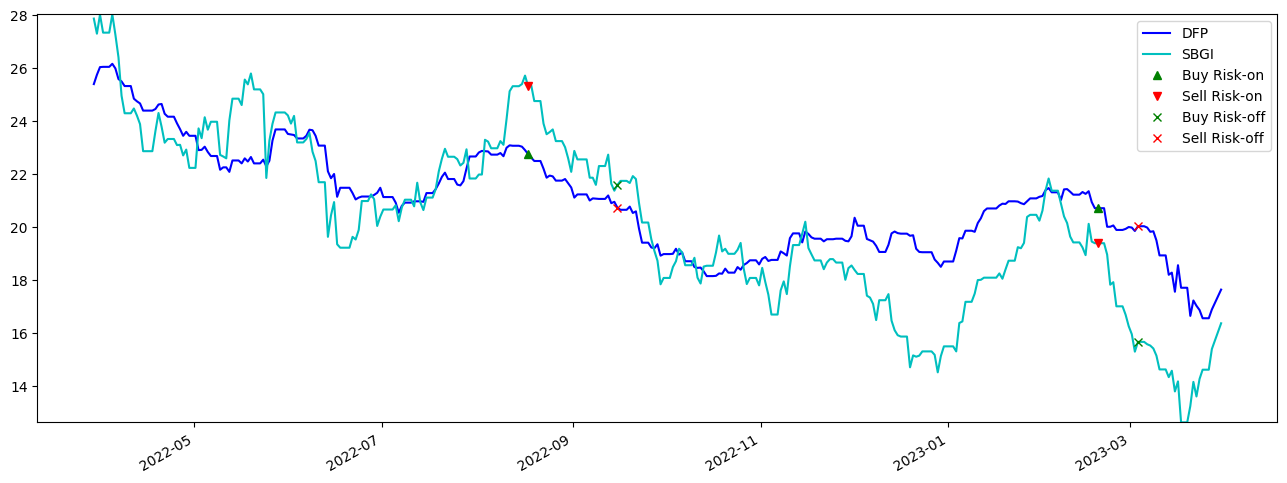

Total reward for this pair: 10.668281906976777
Total return for this pair: 10.668281906976777


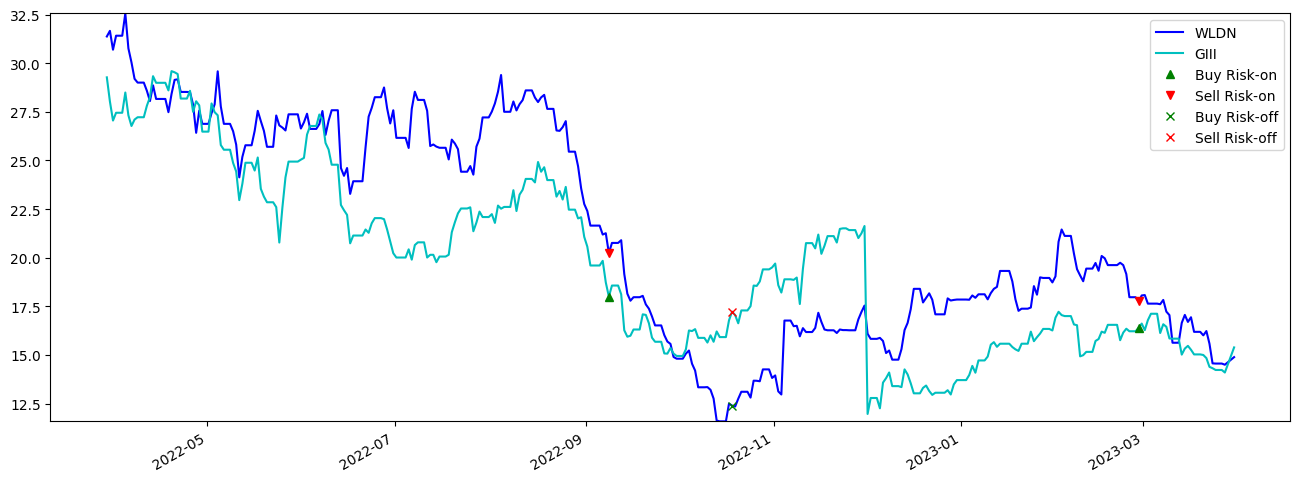

Total reward for this pair: 4.441924777882868
Total return for this pair: 4.441924777882868


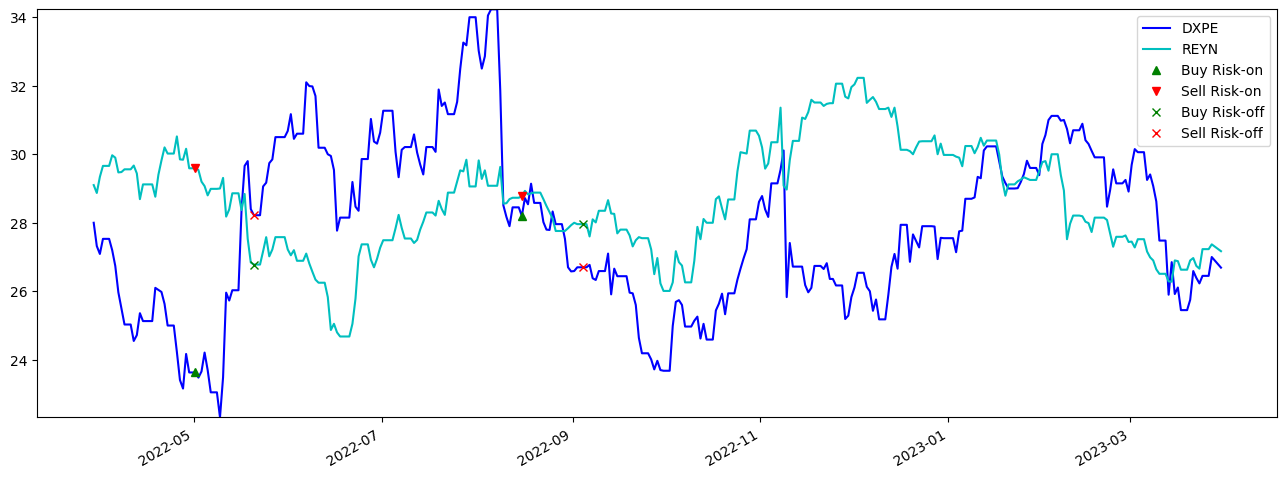

Total reward for this pair: 12.458117751879193
Total return for this pair: 12.458117751879193


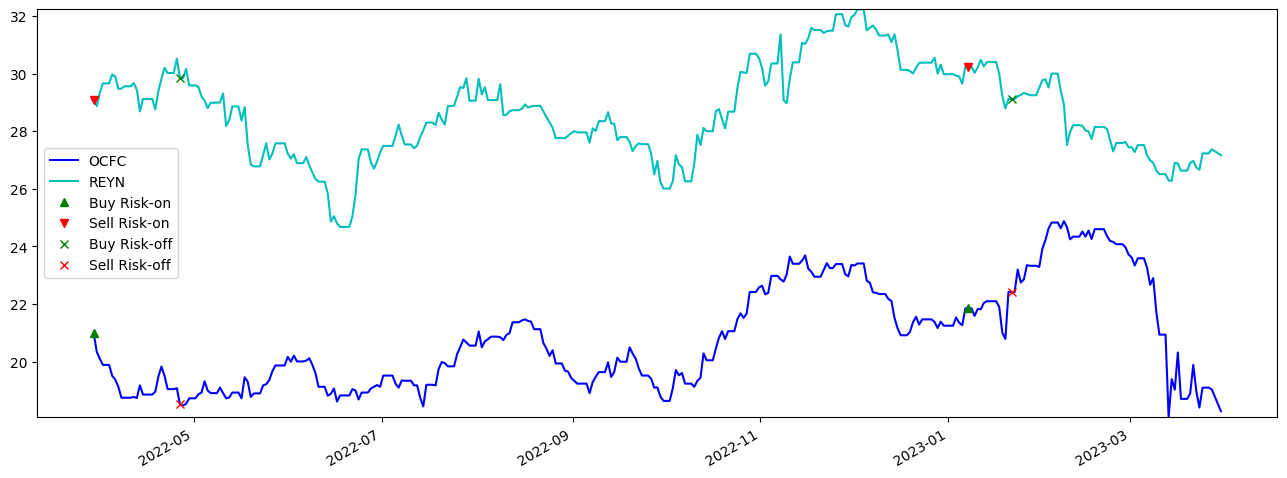

Total reward for this pair: -0.6205153429681622
Total return for this pair: -0.6205153429681622


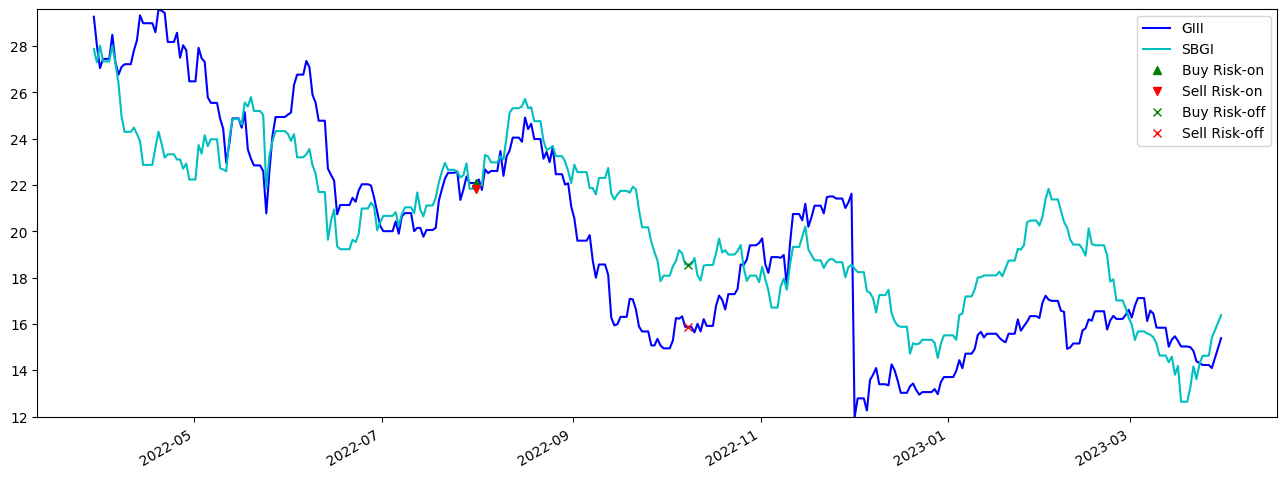

Total reward for this pair: 0.9890335063199425
Total return for this pair: 0.9890335063199425
Average overall rewards: 4.60721092980392
Average overall returns: 4.612305428967324


In [54]:
#plot entries/exits on val data
#fill in latest/best model
policy_net.load_state_dict(torch.load('./models/model (111).pth'))
target_net.load_state_dict(policy_net.state_dict())
policy_net.eval()   #changes forward(); disables Dropout, BatchNorm, etc.
target_net.eval()

plot.plotEntryExits(policy_net, target_net, valenvs, device)

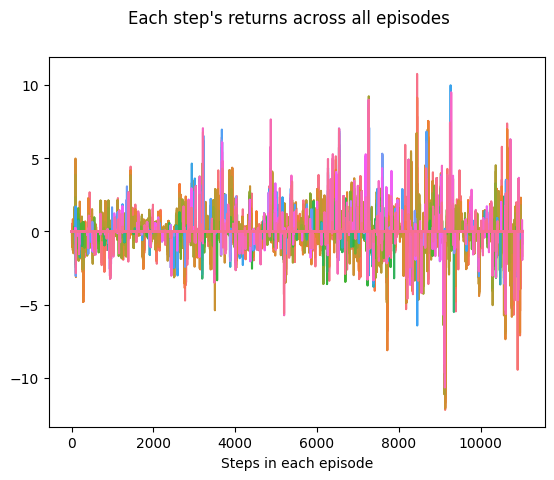

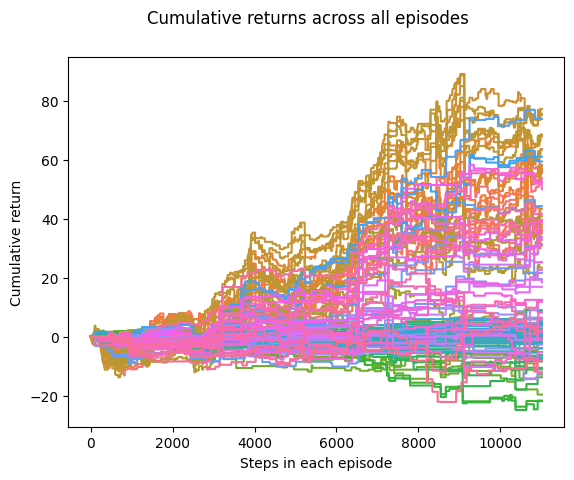

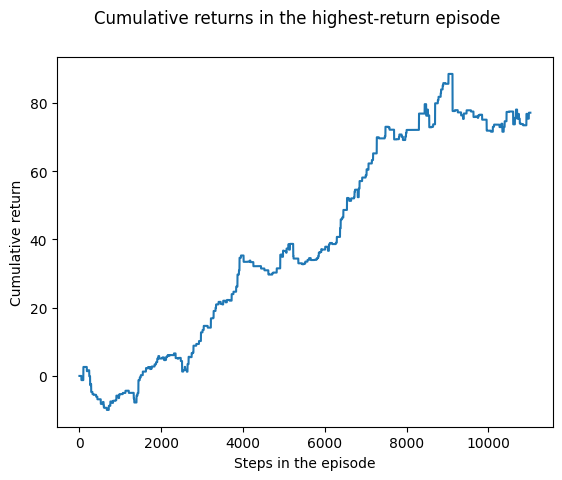

Highest cumulative return in epoch 18, return: 77.16826453047963


In [55]:
plot.plot_episodes(val_return_dict)

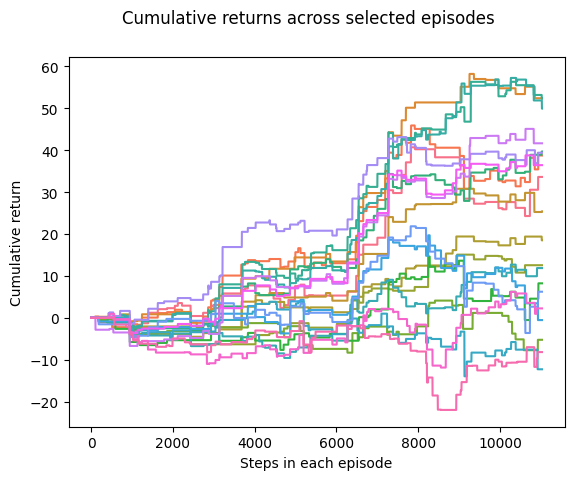

Highest cumulative return in epoch 102, return: 52.42138399374338.


,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11021,33.631981,38.750536,52.421384,25.413531,18.498421,12.555342,-5.250715,8.228642,39.696116,52.311207,51.891731,11.874229,-12.289493,-0.543001,6.226744,39.41247,41.662938,36.446193,2.243012,-8.188798
11022,33.631981,38.750536,52.421384,25.413531,18.498421,12.555342,-5.250715,8.228642,39.696116,52.311207,49.942816,11.874229,-12.289493,-0.543001,6.226744,39.41247,41.662938,36.446193,2.243012,-8.188798
11023,33.631981,38.750536,52.421384,25.413531,18.498421,12.555342,-5.250715,8.228642,39.696116,52.311207,49.942816,11.874229,-12.289493,-0.543001,6.226744,39.41247,41.662938,36.446193,2.243012,-8.188798
11024,33.631981,38.750536,52.421384,25.413531,18.498421,12.555342,-5.250715,8.228642,39.696116,52.311207,49.942816,11.874229,-12.289493,-0.543001,6.226744,39.41247,41.662938,36.446193,2.243012,-8.188798


In [56]:
plot.plot_n_episodes(val_return_dict, 100, 120)

# APPLYING BEST MODEL ON UNSEEN DATA #

In [57]:
#revisit how many stocks in each cluster
for i in good_clusters_dict.keys():
    print(f'cluster {i}: {len(dailyDF[good_clusters_dict[i]].columns)} stocks')

cluster 0: 345 stocks
cluster 3: 214 stocks
cluster 4: 13 stocks
cluster 5: 409 stocks
cluster 7: 80 stocks
cluster 9: 25 stocks


In [58]:
#function to get cluster performance in the testenv of an unseen cluster
def get_cluster_performance(policy_net, target_net, testenvs):
    policy_net.eval()   #changes forward(); disables Dropout, BatchNorm, etc.
    target_net.eval()

    total_rewards = []
    total_returns = []
    with torch.no_grad():
        for testenv in testenvs:
            obs = testenv.reset()
            state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            for t in count():   #keep looping until done -> break
                # Select and perform an action
                action = policy_net(state).max(1)[1].view(1, 1)
                obs, _reward, done, info, _return = testenv.step(Positions(action.item()))
                state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
                
                if done:
                    total_rewards.append(info['total_reward'])
                    total_returns.append(info['total_return'])
                    break

    cluster_rewards = np.mean(total_rewards)
    cluster_returns = np.mean(total_returns)

    return cluster_rewards, cluster_returns

In [59]:
#find overall performance on all good and unseen clusters
def unseen_performance(good_clusters_dict, dailyDF, train_enddate, policy_net, target_net):
    overall_rewards = []
    overall_returns = []

    for i in good_clusters_dict.keys():
        #choose cluster of a reasonable size as test cluster
        dailyDF_test = dailyDF[good_clusters_dict[i]]

        #no need to plot heatmap; just to get the testpairs, testpval, testdf,
        testpairs, _testpval, testdf = pipeline.find_pairs_pv_df(dailyDF_test.loc[train_enddate:].dropna(axis=1, how='all'))
        print(f'Cluster {i} has {len(testpairs)} testpairs.')

        #create testenvs
        testenvs = []
        for testpair in testpairs:
            testdata = testdf[list(testpair)].dropna()
            if testdata.shape[0] > 250:
                #instantiate an env; automatatically run trade()
                testenvs.append(StockTradingEnvironment(testdata.copy(), window_size, transaction_cost))

        #get cluster performance
        cluster_rewards, cluster_returns = get_cluster_performance(policy_net, target_net, testenvs)
        print(f'For cluster {i}, overall reward is {cluster_rewards}, overall return is {cluster_returns}')

        overall_rewards.append(cluster_rewards)
        overall_returns.append(cluster_returns)
    
    print(f'For all clusters, total reward is {np.sum(overall_rewards)}, total return is {np.sum(overall_returns)}.')
    print(f'Average reward is {np.mean(overall_rewards)}, average return is {np.mean(overall_returns)}.')
        

In [60]:
#Average out all unseen clusters n times
def avg_n_performance(n, good_clusters_dict, dailyDF, train_enddate, policy_net, target_net):
    avg_n_rewards = []
    avg_n_returns = []

    for e in range(n):

        ep_rewards = []
        ep_returns = []
        
        #loop through each good cluster
        for i in good_clusters_dict.keys():
            dailyDF_test = dailyDF[good_clusters_dict[i]]

            #no need to plot heatmap; just to get the testpairs, testpval, testdf,
            testpairs, _testpval, testdf = pipeline.find_pairs_pv_df(dailyDF_test.loc[train_enddate:].dropna(axis=1, how='all'))

            #create testenvs
            testenvs = []
            for testpair in testpairs:
                testdata = testdf[list(testpair)].dropna()
                if testdata.shape[0] > 250:
                    #instantiate an env; automatatically run trade()
                    testenvs.append(StockTradingEnvironment(testdata.copy(), window_size, transaction_cost))

            #get cluster performance
            cluster_rewards, cluster_returns = get_cluster_performance(policy_net, target_net, testenvs)
            
            ep_rewards.append(cluster_rewards)
            ep_returns.append(cluster_returns)
        
        avg_n_rewards.append(np.mean(ep_rewards))
        avg_n_returns.append(np.mean(ep_returns))
    
    #Plot all cumulative sums
    sns.lineplot(data=avg_n_rewards, legend=False, dashes=False)#, palette=['pink'], dashes=False, legend=False)
    
    # Set the plot title and axis labels
    plt.suptitle('Trendline showing average rewards across all clusters')
    plt.xlabel('Iterations')
    plt.ylabel('Average rewards')
    plt.show()

    sns.lineplot(data=avg_n_returns, legend=False, dashes=False)#, palette=['pink'], dashes=False, legend=False)
    # Set the plot title and axis labels
    plt.suptitle('Trendline showing average returns across all clusters')
    plt.xlabel('Iterations')
    plt.ylabel('Average returns')
    plt.show()

    print(f'The average rewards and returns after {n} iterations are respectively {np.mean(avg_n_rewards)} and {np.mean(avg_n_returns)}.')
        

In [61]:
#One iteration of performance of all clusters
unseen_performance(good_clusters_dict, dailyDF, train_enddate, policy_net, target_net)

Cluster 0 has 26 testpairs.
For cluster 0, overall reward is 0.549584544194525, overall return is 0.549584544194525
Cluster 3 has 20 testpairs.
For cluster 3, overall reward is -4.483456998961799, overall return is -4.465397320796052
Cluster 4 has 13 testpairs.
For cluster 4, overall reward is 3.772703305287233, overall return is 3.7766211373064404
Cluster 5 has 99 testpairs.
For cluster 5, overall reward is -0.10097903178586494, overall return is -0.10032250091066343
Cluster 7 has 22 testpairs.
For cluster 7, overall reward is 1.1864232882257648, overall return is 1.2628601212551767
Cluster 9 has 15 testpairs.
For cluster 9, overall reward is -0.8097251742392818, overall return is -0.8097251742392818
For all clusters, total reward is 0.11454993272057712, total return is 0.2136208068101445.
Average reward is 0.01909165545342952, average return is 0.03560346780169075.


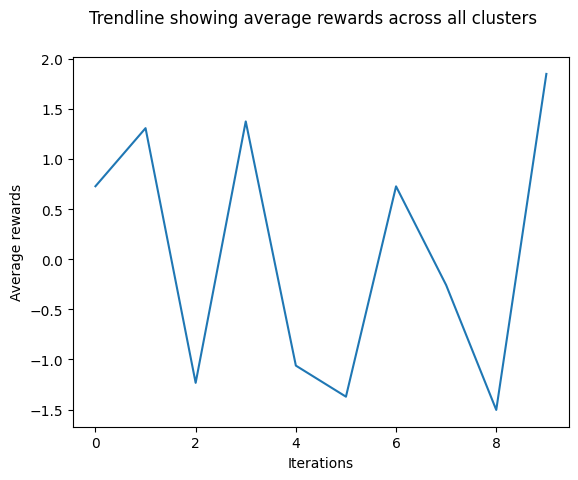

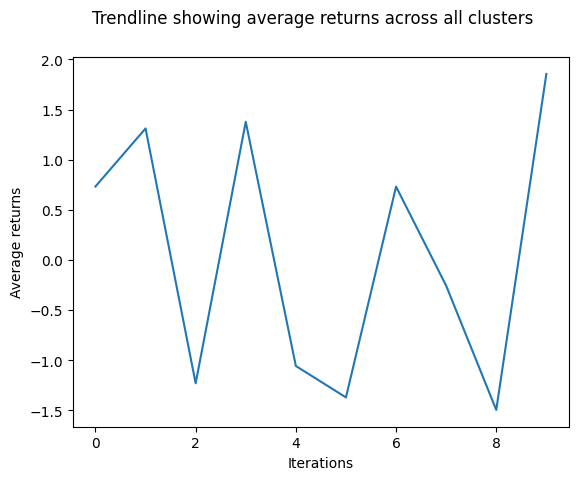

The average rewards and returns after 10 iterations are respectively 0.056668539646650286 and 0.059811198902883354.


In [62]:
#average out the performances of all clusters over total_iter times
total_iter = 10
avg_n_performance(total_iter, good_clusters_dict, dailyDF, train_enddate, policy_net, target_net)